In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/paldat_images.zip"
extract_to = "/content/paldat_images"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print("The zip file has been extracted. ")
else:
    print(" The zip file had already been extracted, so it was not extracted again.")

print(" The folder is ready:", extract_to)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Zip dosyası çıkarıldı.
🔗 Klasör hazır: /content/paldat_images


In [ ]:
import shutil
import os

root = "/content/paldat_images"
inner = os.path.join(root, "paldat_images")

if os.path.exists(inner):
    for item in os.listdir(inner):
        s = os.path.join(inner, item)
        d = os.path.join(root, item)
        shutil.move(s, d)

    shutil.rmtree(inner)
    print(" Nested folder fixed and old folder removed.")
else:
    print("ℹ No nested folder found, moving was not required.")

✅ İç içe klasör düzeltildi ve eski klasör silindi.


In [ ]:
import shutil
import os

sample_data_path = "/content/sample_data"

if os.path.exists(sample_data_path):
    shutil.rmtree(sample_data_path)
    print(" sample_data folder deleted.")
else:
    print("ℹ sample_data folder does not exist.")

✅ sample_data klasörü silindi.


In [ ]:


import os
import cv2
import numpy as np
import statistics
from typing import List, Tuple, Iterable


def get_morph_boxes(img: np.ndarray) -> List[Tuple[int, int, int, int]]:

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thr = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    mask = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    boxes: List[Tuple[int, int, int, int]] = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w < 50 or h < 50:
            continue
        boxes.append((x, y, x + w, y + h))
    return boxes


def get_edge_boxes(img: np.ndarray) -> List[Tuple[int, int, int, int]]:

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    median = np.median(blur)
    low = int(max(5, 0.3 * median))
    high = int(min(255, 1.2 * median))
    edges = cv2.Canny(blur, low, high)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    edges_dil = cv2.dilate(edges, kernel, iterations=2)
    closed = cv2.morphologyEx(edges_dil, cv2.MORPH_CLOSE, kernel)
    h, w = closed.shape
    ff_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)
    inv = 255 - closed.copy()
    cv2.floodFill(inv, ff_mask, (0, 0), 255)
    filled = cv2.bitwise_not(inv)
    opened = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel)
    cnts, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    boxes: List[Tuple[int, int, int, int]] = []
    for c in cnts:
        x, y, wc, hc = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        if wc < 70 or hc < 70 or area < 3000:
            continue
        aspect = wc / float(hc)
        if aspect > 5 or aspect < 0.2:
            continue
        boxes.append((x, y, x + wc, y + hc))
    return boxes


def iou(box1: Tuple[int, int, int, int],
        box2: Tuple[int, int, int, int]) -> float:
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x2 <= x1 or y2 <= y1:
        return 0.0
    inter = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return inter / float(area1 + area2 - inter)


def merge_boxes(boxes: Iterable[Tuple[int, int, int, int]],
                iou_thresh: float = 0.2) -> List[Tuple[int, int, int, int]]:

    merged: List[Tuple[int, int, int, int]] = []
    for box in sorted(boxes, key=lambda b: (b[0], b[1])):
        merged_flag = False
        for idx, m in enumerate(merged):
            if iou(box, m) > iou_thresh:
                # union of overlapping boxes
                x1 = min(box[0], m[0])
                y1 = min(box[1], m[1])
                x2 = max(box[2], m[2])
                y2 = max(box[3], m[3])
                merged[idx] = (x1, y1, x2, y2)
                merged_flag = True
                break
        if not merged_flag:
            merged.append(box)
    return merged


def filter_contained(boxes: Iterable[Tuple[int, int, int, int]]) -> List[Tuple[int, int, int, int]]:
    boxes = list(boxes)
    result: List[Tuple[int, int, int, int]] = []
    for i, box in enumerate(boxes):
        contained = False
        for j, other in enumerate(boxes):
            if i == j:
                continue
            if (box[0] >= other[0] and box[1] >= other[1] and
                box[2] <= other[2] and box[3] <= other[3]):
                contained = True
                break
        if not contained:
            result.append(box)
    return result


def valley_mask_segments(mask: np.ndarray, ratio: float = 0.6) -> List[Tuple[int, int]]:

    arr = (mask > 0).astype(np.uint8)
    proj = arr.sum(axis=0).astype(np.float32)
    smooth = cv2.GaussianBlur(proj.reshape(1, -1), (31, 1), 0).ravel()
    mx = float(smooth.max())
    mn = float(smooth.min())
    if mx <= 0:
        return []
    threshold = mn + (mx - mn) * ratio
    below = np.where(smooth <= threshold)[0]
    if below.size == 0:
        return []
    segments: List[Tuple[int, int]] = []
    start = int(below[0])
    prev = int(below[0])
    for idx in below[1:]:
        if int(idx) == prev + 1:
            prev = int(idx)
        else:
            segments.append((start, prev))
            start = int(idx)
            prev = int(idx)
    segments.append((start, prev))
    width = mask.shape[1]
    filtered: List[Tuple[int, int]] = []
    for s, e in segments:
        seg_w = e - s + 1
        if s < width * 0.05 or e > width * 0.95:
            continue
        if seg_w < width * 0.05:
            continue
        filtered.append((s, e))
    return filtered


def split_box_horiz(box: Tuple[int, int, int, int], parts: int) -> List[Tuple[int, int, int, int]]:
    x1, y1, x2, y2 = box
    width = x2 - x1
    seg_w = width / float(parts)
    result: List[Tuple[int, int, int, int]] = []
    for i in range(parts):
        sx1 = int(round(x1 + i * seg_w))
        sx2 = int(round(x1 + (i + 1) * seg_w))
        result.append((sx1, y1, sx2, y2))
    return result


def detect_pollen_boxes_auto(img: np.ndarray, global_med_width: float,
                             large_thresh: float = 1.6,
                             valley_ratio: float = 0.6) -> List[Tuple[int, int, int, int]]:
    boxes = merge_boxes(get_morph_boxes(img) + get_edge_boxes(img))
    boxes = filter_contained(boxes)
    final: List[Tuple[int, int, int, int]] = []
    for b in boxes:
        x1, y1, x2, y2 = b
        width = x2 - x1
        if global_med_width > 0 and width > global_med_width * large_thresh:
            sub = img[y1:y2, x1:x2]
            gray = cv2.cvtColor(sub, cv2.COLOR_BGR2GRAY)
            _, thr = cv2.threshold(gray, 0, 255,
                                   cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
            mask = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            valleys = valley_mask_segments(mask, ratio=valley_ratio)
            count = len(valleys) + 1 if valleys else 2
            approx = max(1, int(round(width / global_med_width)))
            if count > approx + 1:
                count = approx + 1
            count = max(count, 2)
            final.extend(split_box_horiz(b, count))
        else:
            final.append(b)
    final_sorted = sorted(final, key=lambda bx: (bx[0], bx[1]))
    return final_sorted


def crop_and_save(img: np.ndarray,
                  boxes: Iterable[Tuple[int, int, int, int]],
                  base_name: str,
                  out_dir: str,
                  margin_ratio: float = 0.05) -> None:
    os.makedirs(out_dir, exist_ok=True)
    h_img, w_img = img.shape[:2]
    stem, _ = os.path.splitext(base_name)
    for idx, b in enumerate(boxes, start=1):
        x1, y1, x2, y2 = b
        w = x2 - x1
        h = y2 - y1
        mw = int(w * margin_ratio)
        mh = int(h * margin_ratio)
        cx1 = max(0, x1 - mw)
        cy1 = max(0, y1 - mh)
        cx2 = min(w_img, x2 + mw)
        cy2 = min(h_img, y2 + mh)
        crop = img[cy1:cy2, cx1:cx2]
        out_name = f"{stem}_{idx}.jpg"
        cv2.imwrite(os.path.join(out_dir, out_name), crop)


def compute_global_median_width(image_paths: List[str]) -> float:
    widths: List[int] = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        boxes = merge_boxes(get_morph_boxes(img) + get_edge_boxes(img))
        boxes = filter_contained(boxes)
        widths.extend([b[2] - b[0] for b in boxes])
    return statistics.median(widths) if widths else 0.0


def main() -> None:
    script_dir = '/content'
    input_root = os.path.join(script_dir, 'paldat_images')
    output_root = os.path.join(script_dir, 'cropped_paldat_images')
    failed_root = os.path.join(script_dir, 'uncropped_paldat_images')

    if not os.path.isdir(input_root):
        print(f"Input directory '{input_root}' not found.  Nothing to do.")
        return

    image_paths: List[str] = []
    for root, _, files in os.walk(input_root):
        for fname in files:
            f_lower = fname.lower()
            if f_lower.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, fname))

    if not image_paths:
        print(f"No images found in '{input_root}'.")
        return

    global_median = compute_global_median_width(image_paths)
    total_crops = 0

    for root, _, files in os.walk(input_root):
        rel_root = os.path.relpath(root, input_root)
        out_dir = os.path.join(output_root, rel_root)
        fail_dir = failed_root

        for fname in files:
            f_lower = fname.lower()
            if not f_lower.endswith(('.jpg', '.jpeg', '.png')):
                continue
            img_path = os.path.join(root, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            boxes = detect_pollen_boxes_auto(img, global_median,
                                             large_thresh=1.6,
                                             valley_ratio=0.6)
            if not boxes:
                print(f"  No pollen found to crop inside '{img_path}'.")
                os.makedirs(fail_dir, exist_ok=True)

                fail_name = f"{os.path.basename(root)}_{fname}"
                fail_path = os.path.join(fail_dir, fail_name)
                shutil.copy2(img_path, fail_path)
                print(f" Copied: '{fail_path}'")

            else:
                crop_and_save(img, boxes, fname, out_dir, margin_ratio=0.05)
                total_crops += len(boxes)

    print(f"Processed {len(image_paths)} images.  Saved {total_crops} crops into '{output_root}'.")



if __name__ == '__main__':
    main()

⚠️  '/content/paldat_images/Plantaginaceae/Microrrhinum/Microrrhinum_minus_2.jpg' içinde kırpılacak hiçbir polen bulunamadı.
📂 Kopyalandı: '/content/uncropped_paldat_images/Microrrhinum_Microrrhinum_minus_2.jpg'
⚠️  '/content/paldat_images/Plantaginaceae/Plantago/Plantago_lanceolata_5.jpg' içinde kırpılacak hiçbir polen bulunamadı.
📂 Kopyalandı: '/content/uncropped_paldat_images/Plantago_Plantago_lanceolata_5.jpg'
⚠️  '/content/paldat_images/Plantaginaceae/Cymbalaria/Cymbalaria_muralis_6.jpg' içinde kırpılacak hiçbir polen bulunamadı.
📂 Kopyalandı: '/content/uncropped_paldat_images/Cymbalaria_Cymbalaria_muralis_6.jpg'
⚠️  '/content/paldat_images/Plantaginaceae/Cymbalaria/Cymbalaria_muralis_2.jpg' içinde kırpılacak hiçbir polen bulunamadı.
📂 Kopyalandı: '/content/uncropped_paldat_images/Cymbalaria_Cymbalaria_muralis_2.jpg'
⚠️  '/content/paldat_images/Hamamelidaceae/Corylopsis/Corylopsis_spicata_3.jpg' içinde kırpılacak hiçbir polen bulunamadı.
📂 Kopyalandı: '/content/uncropped_paldat_im

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class FamilyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        self.families = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.family_to_idx = {fam: i for i, fam in enumerate(self.families)}

        for family in self.families:
            family_path = os.path.join(root_dir, family)
            for root, _, files in os.walk(family_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        path = os.path.join(root, file)
                        self.image_paths.append(path)
                        self.labels.append(self.family_to_idx[family])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


📊 Familya bazlı örnek sayıları:

Asteraceae                → 4528 görsel
Fabaceae                  → 2384 görsel
Rosaceae                  → 1772 görsel
Lamiaceae                 → 1595 görsel
Brassicaceae              → 1478 görsel
Ranunculaceae             → 1331 görsel
Plantaginaceae            → 882 görsel
Apiaceae                  → 820 görsel
Caryophyllaceae           → 740 görsel
Caprifoliaceae            → 544 görsel
Boraginaceae              → 506 görsel
Campanulaceae             → 488 görsel
Orobanchaceae             → 484 görsel
Primulaceae               → 455 görsel
Gentianaceae              → 432 görsel
Solanaceae                → 415 görsel
Papaveraceae              → 413 görsel
Scrophulariaceae          → 397 görsel
Amaryllidaceae            → 387 görsel
Asparagaceae              → 372 görsel
Poaceae                   → 369 görsel
Cyperaceae                → 346 görsel
Malvaceae                 → 342 görsel
Euphorbiaceae             → 330 görsel
Rubiaceae                

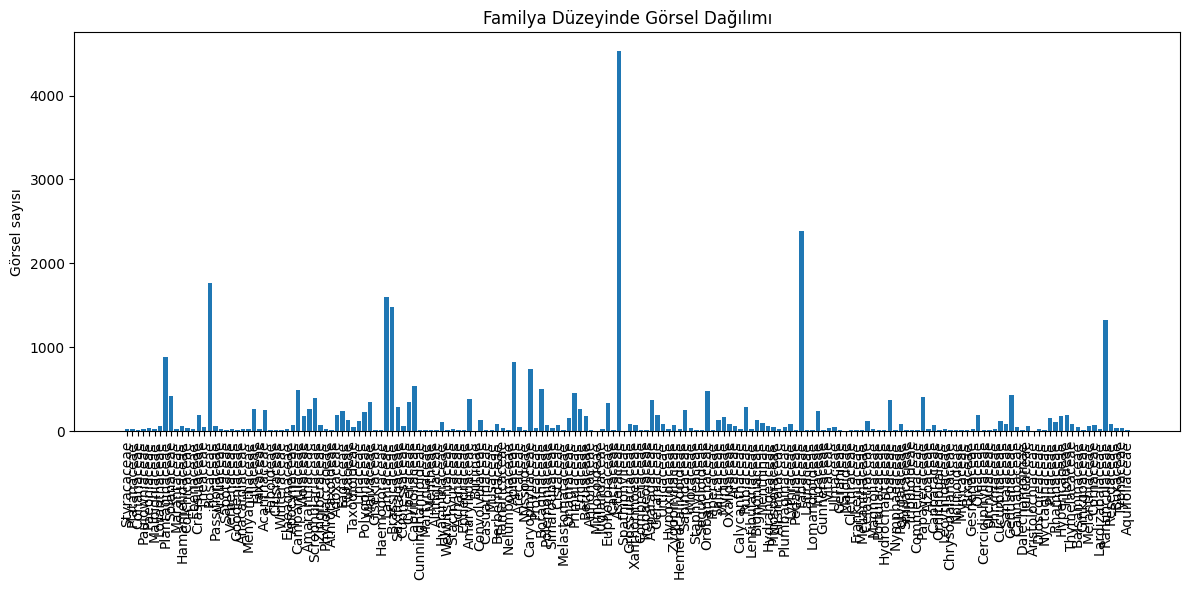

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

root_dir = "/content/cropped_paldat_images"

family_counter = Counter()

for family in os.listdir(root_dir):
    family_path = os.path.join(root_dir, family)
    if not os.path.isdir(family_path):
        continue

    count = 0
    for root, _, files in os.walk(family_path):
        count += sum(1 for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png')))

    family_counter[family] = count

print("Sample counts per family:\n")
for fam, cnt in sorted(family_counter.items(), key=lambda x: x[1], reverse=True):
    print(f"{fam:25s} → {cnt} images")

plt.figure(figsize=(12, 6))
plt.bar(family_counter.keys(), family_counter.values())
plt.xticks(rotation=90)
plt.ylabel("Number of images")
plt.title("Image Distribution per Family")
plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import random
from collections import Counter

def prepare_balanced_dataset(
    input_dir="/content/cropped_paldat_images",
    output_dir="/content/cropped_balanced",
    min_samples=100,
    max_samples=1000,
    extensions=('.jpg', '.jpeg', '.png')
):
    os.makedirs(output_dir, exist_ok=True)
    included = 0

    for family in os.listdir(input_dir):
        family_path = os.path.join(input_dir, family)
        if not os.path.isdir(family_path):
            continue

        image_paths = []
        for root, _, files in os.walk(family_path):
            for file in files:
                if file.lower().endswith(extensions):
                    image_paths.append(os.path.join(root, file))

        n = len(image_paths)

        if n < min_samples:
            continue

        if n > max_samples:
            image_paths = random.sample(image_paths, max_samples)

        target_dir = os.path.join(output_dir, family)
        os.makedirs(target_dir, exist_ok=True)

        for i, src_path in enumerate(image_paths):
            fname = f"{family}_{i+1}.jpg"
            dst_path = os.path.join(target_dir, fname)
            shutil.copy2(src_path, dst_path)

        print(f"{family:25s} → {len(image_paths)} images copied.")
        included += 1

    print(f"\nTotal {included} families processed → {output_dir}")

prepare_balanced_dataset()

✅ Plantaginaceae            → 882 görsel kopyalandı.
✅ Solanaceae                → 415 görsel kopyalandı.
✅ Crassulaceae              → 194 görsel kopyalandı.
✅ Rosaceae                  → 1000 görsel kopyalandı.
✅ Liliaceae                 → 260 görsel kopyalandı.
✅ Acanthaceae               → 254 görsel kopyalandı.
✅ Campanulaceae             → 488 görsel kopyalandı.
✅ Violaceae                 → 179 görsel kopyalandı.
✅ Amaranthaceae             → 270 görsel kopyalandı.
✅ Scrophulariaceae          → 397 görsel kopyalandı.
✅ Adoxaceae                 → 189 görsel kopyalandı.
✅ Fagaceae                  → 241 görsel kopyalandı.
✅ Rutaceae                  → 137 görsel kopyalandı.
✅ Linaceae                  → 118 görsel kopyalandı.
✅ Polygonaceae              → 226 görsel kopyalandı.
✅ Malvaceae                 → 342 görsel kopyalandı.
✅ Lamiaceae                 → 1000 görsel kopyalandı.
✅ Brassicaceae              → 1000 görsel kopyalandı.
✅ Saxifragaceae             → 283 görsel ko

In [ ]:
import os
import shutil
import random

def split_balanced_dataset(
    input_dir="/content/cropped_balanced",
    output_dir="/content/cropped_split_balanced",
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    extensions=('.jpg', '.jpeg', '.png')
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."
    split_counts = {"train": 0, "val": 0, "test": 0}

    for family in os.listdir(input_dir):
        family_path = os.path.join(input_dir, family)
        if not os.path.isdir(family_path):
            continue

        images = [
            os.path.join(family_path, f)
            for f in os.listdir(family_path)
            if f.lower().endswith(extensions)
        ]
        random.shuffle(images)

        n = len(images)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        splits = {
            "train": images[:n_train],
            "val": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split_name, paths in splits.items():
            split_family_dir = os.path.join(output_dir, split_name, family)
            os.makedirs(split_family_dir, exist_ok=True)
            for path in paths:
                shutil.copy2(path, os.path.join(split_family_dir, os.path.basename(path)))
            split_counts[split_name] += len(paths)

        print(f"family:25s} → train: {len(splits['train'])}, val: {len(splits['val'])}, test: {len(splits['test'])}")

    print("\nSplit completed:")
    for k, v in split_counts.items():
        print(f"   {k}: {v} images → {os.path.join(output_dir, k)}")

split_balanced_dataset()

📤 Plantaginaceae            → train: 617, val: 132, test: 133
📤 Solanaceae                → train: 290, val: 62, test: 63
📤 Crassulaceae              → train: 135, val: 29, test: 30
📤 Rosaceae                  → train: 700, val: 150, test: 150
📤 Liliaceae                 → train: 182, val: 39, test: 39
📤 Acanthaceae               → train: 177, val: 38, test: 39
📤 Campanulaceae             → train: 341, val: 73, test: 74
📤 Violaceae                 → train: 125, val: 26, test: 28
📤 Amaranthaceae             → train: 189, val: 40, test: 41
📤 Scrophulariaceae          → train: 277, val: 59, test: 61
📤 Adoxaceae                 → train: 132, val: 28, test: 29
📤 Fagaceae                  → train: 168, val: 36, test: 37
📤 Rutaceae                  → train: 95, val: 20, test: 22
📤 Linaceae                  → train: 82, val: 17, test: 19
📤 Polygonaceae              → train: 158, val: 33, test: 35
📤 Malvaceae                 → train: 239, val: 51, test: 52
📤 Lamiaceae                 → train: 7

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import os

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_dir = "/content/cropped_split_balanced"

train_dataset = ImageFolder(os.path.join(base_dir, "train"), transform=transform_train)
val_dataset   = ImageFolder(os.path.join(base_dir, "val"), transform=transform_eval)
test_dataset  = ImageFolder(os.path.join(base_dir, "test"), transform=transform_eval)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")
print("Class mapping:", train_dataset.class_to_idx)


✅ Train: 14260 örnek
✅ Val:   3038 örnek
✅ Test:  3108 örnek
📚 Sınıf eşleşmeleri: {'Acanthaceae': 0, 'Adoxaceae': 1, 'Amaranthaceae': 2, 'Amaryllidaceae': 3, 'Apiaceae': 4, 'Asparagaceae': 5, 'Asteraceae': 6, 'Betulaceae': 7, 'Bignoniaceae': 8, 'Boraginaceae': 9, 'Brassicaceae': 10, 'Campanulaceae': 11, 'Caprifoliaceae': 12, 'Caryophyllaceae': 13, 'Celastraceae': 14, 'Convolvulaceae': 15, 'Crassulaceae': 16, 'Cucurbitaceae': 17, 'Cyperaceae': 18, 'Ericaceae': 19, 'Euphorbiaceae': 20, 'Fabaceae': 21, 'Fagaceae': 22, 'Gentianaceae': 23, 'Geraniaceae': 24, 'Hyacinthaceae': 25, 'Hypericaceae': 26, 'Iridaceae': 27, 'Lamiaceae': 28, 'Liliaceae': 29, 'Linaceae': 30, 'Malvaceae': 31, 'Myrtaceae': 32, 'Oleaceae': 33, 'Onagraceae': 34, 'Orobanchaceae': 35, 'Papaveraceae': 36, 'Pinaceae': 37, 'Plantaginaceae': 38, 'Poaceae': 39, 'Polygonaceae': 40, 'Primulaceae': 41, 'Ranunculaceae': 42, 'Rhamnaceae': 43, 'Rosaceae': 44, 'Rubiaceae': 45, 'Rutaceae': 46, 'Salicaceae': 47, 'Sapindaceae': 48, 'Saxif

ResNet18 Modelini Kur ve Hazırla

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)

num_classes = len(train_dataset.classes)

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


💻 Kullanılan cihaz: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

best_val_acc = 0.0
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_family_model.pth")
        print(" Best model saved.")


📦 Epoch 1/20
  🟩 Train Loss: 2.4462 | Acc: 0.3832
  🟨 Val   Loss: 1.7836 | Acc: 0.5184
  💾 En iyi model kaydedildi.
📦 Epoch 2/20
  🟩 Train Loss: 1.5381 | Acc: 0.5825
  🟨 Val   Loss: 1.4846 | Acc: 0.5876
  💾 En iyi model kaydedildi.
📦 Epoch 3/20
  🟩 Train Loss: 1.1391 | Acc: 0.6881
  🟨 Val   Loss: 1.2019 | Acc: 0.6580
  💾 En iyi model kaydedildi.
📦 Epoch 4/20
  🟩 Train Loss: 0.8572 | Acc: 0.7649
  🟨 Val   Loss: 1.1143 | Acc: 0.6820
  💾 En iyi model kaydedildi.
📦 Epoch 5/20
  🟩 Train Loss: 0.6449 | Acc: 0.8234
  🟨 Val   Loss: 1.0355 | Acc: 0.7014
  💾 En iyi model kaydedildi.
📦 Epoch 6/20
  🟩 Train Loss: 0.4792 | Acc: 0.8720
  🟨 Val   Loss: 0.9955 | Acc: 0.7117
  💾 En iyi model kaydedildi.
📦 Epoch 7/20
  🟩 Train Loss: 0.3581 | Acc: 0.9067
  🟨 Val   Loss: 0.9818 | Acc: 0.7255
  💾 En iyi model kaydedildi.
📦 Epoch 8/20
  🟩 Train Loss: 0.2678 | Acc: 0.9340
  🟨 Val   Loss: 1.0359 | Acc: 0.7179
📦 Epoch 9/20
  🟩 Train Loss: 0.2204 | Acc: 0.9421
  🟨 Val   Loss: 0.9944 | Acc: 0.7294
  💾 En iyi mod

In [ ]:
model.load_state_dict(torch.load("best_family_model.pth"))
model.eval()

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
labels = train_dataset.classes

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

report = classification_report(all_labels, all_preds, target_names=labels, digits=3)
print("Class-based Performance Report:\n")
print(report)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Sans'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=train_dataset.classes, columns=train_dataset.classes)

confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append(((train_dataset.classes[i], train_dataset.classes[j]), cm[i, j]))

top_confused = sorted(confusion_pairs, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Most Confused Family Pairs:\n")
for (true_class, pred_class), count in top_confused:
    print(f"{true_class} ↔ {pred_class} : {count} times")

confused_classes = list(set([cls for pair, _ in top_confused for cls in pair]))
confused_indices = [train_dataset.classes.index(cls) for cls in confused_classes]
confused_cm = cm[np.ix_(confused_indices, confused_indices)]
confused_labels = [train_dataset.classes[i] for i in confused_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(confused_cm, annot=True, fmt='d', xticklabels=confused_labels, yticklabels=confused_labels, cmap='Reds')
plt.title("Most Confused Families (with GPU)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [ ]:
import os

test_root = "/content/cropped_split_balanced/test"
print(sorted(os.listdir(test_root)))

In [ ]:
import os

base_path = "/content/cropped_split_balanced"

for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:3]:
        print(f"{subindent}{f}")